Setup & Imports

In [9]:
!pip install --quiet pandas numpy matplotlib seaborn scikit-learn xgboost statsmodels shap gdown

In [10]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
import xgboost as xgb
from scipy.stats import mannwhitneyu, ttest_ind
import shap
import os

In [11]:
os.makedirs("csv_files", exist_ok=True)
os.makedirs("outputs", exist_ok=True)

Data Ingestion

In [12]:
from google.colab import files
print("Upload your two CSVs: Hyperliquid trades + Fear/Greed index")
uploaded = files.upload()


# Adjust filenames if different
trades = pd.read_csv("/content/csv_files/historical_data.csv", low_memory=False)
sent = pd.read_csv("/content/csv_files/fear_greed_index.csv", low_memory=False)


print("Trades shape:", trades.shape)
print("Sentiment shape:", sent.shape)


# Save raw copies
trades.to_csv("csv_files/trades_raw.csv", index=False)
sent.to_csv("csv_files/sent_raw.csv", index=False)

Upload your two CSVs: Hyperliquid trades + Fear/Greed index


Trades shape: (27932, 16)
Sentiment shape: (2644, 4)


Cleaning & Standardization

In [13]:
# Normalize column names
trades.columns = [c.strip().lower().replace(" ", "_") for c in trades.columns]
sent.columns = [c.strip().lower().replace(" ", "_") for c in sent.columns]


print("Trade columns:", trades.columns.tolist())
print("Sentiment columns:", sent.columns.tolist())


# Parse datetime (trades)
if 'timestamp' in trades.columns: # Corrected from 'time' to 'timestamp'
    trades['time'] = pd.to_datetime(trades['timestamp'], errors='coerce', unit='ms') # Use 'timestamp'
    trades['trade_date'] = trades['time'].dt.date


# Parse sentiment date
if 'date' in sent.columns:
    sent['date'] = pd.to_datetime(sent['date'], errors='coerce').dt.date


# Map sentiment classification → score
mapping = {'Extreme Fear':0.0,'Fear':0.25,'Neutral':0.5,'Greed':0.75,'Extreme Greed':1.0}
if 'classification' in sent.columns:
    sent['sentiment_score'] = sent['classification'].map(mapping)


# Merge datasets by date
merged = trades.merge(sent[['date','classification','sentiment_score']],
left_on='trade_date', right_on='date', how='left')


print("Merged shape:", merged.shape)

Trade columns: ['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side', 'timestamp_ist', 'start_position', 'direction', 'closed_pnl', 'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id', 'timestamp']
Sentiment columns: ['timestamp', 'value', 'classification', 'date']
Merged shape: (27932, 21)


Feature Engineering

In [14]:
# Basic features
merged['closed_pnl'] = pd.to_numeric(merged['closed_pnl'], errors='coerce')
merged['execution_price'] = pd.to_numeric(merged['execution_price'], errors='coerce')
merged['size_tokens'] = pd.to_numeric(merged['size_tokens'], errors='coerce')

merged['notional'] = merged['size_tokens'].abs() * merged['execution_price']
merged['norm_return'] = merged['closed_pnl'] / (merged['notional'] + 1e-9)
merged['profitable'] = (merged['closed_pnl'] > 0).astype(int)

merged[['closed_pnl','norm_return','profitable']].describe()

,closed_pnl,norm_return,profitable
count,27932.000000,27932.000000,27932.000000
mean,128.515645,0.020260,0.378097
std,1891.720251,0.084472,0.484921
min,-117990.104100,-1.228838,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,11.583865,0.004485,1.000000
max,135329.090100,1.594756,1.000000


Exploratory Data Analysis (EDA) -
Here we examine the distribution of closed PnL and its variation across Fear/Greed classes.

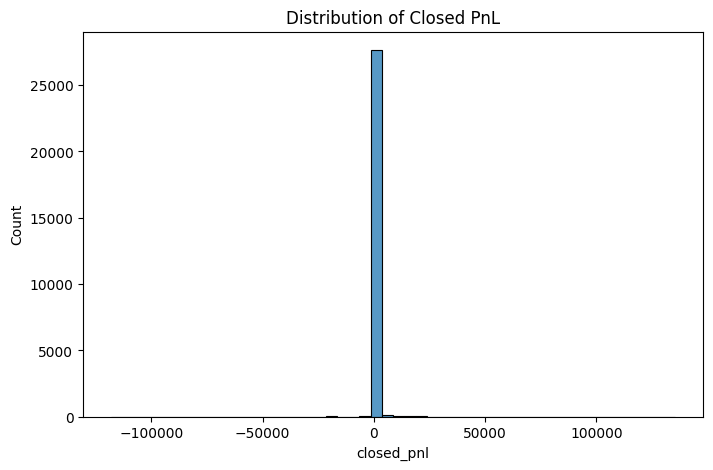

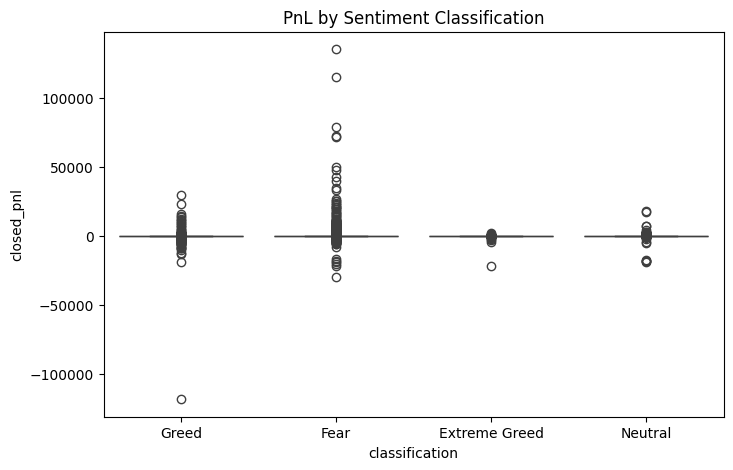

  classification    mean_pnl  win_rate  trades
0  Extreme Greed   -9.681505  0.273839     818
1           Fear  189.287392  0.399720   15721
2          Greed    5.446001  0.235294    3094
3        Neutral   76.747074  0.430680    1558


In [15]:
plt.figure(figsize=(8,5))
sns.histplot(merged['closed_pnl'].dropna(), bins=50, kde=False)
plt.title("Distribution of Closed PnL")
plt.savefig("outputs/pnl_distribution.png", dpi=200)
plt.show()


plt.figure(figsize=(8,5))
sns.boxplot(x='classification', y='closed_pnl', data=merged)
plt.title("PnL by Sentiment Classification")
plt.savefig("outputs/box_pnl_by_sent.png", dpi=200)
plt.show()


# Grouped summary
summary = merged.groupby('classification').agg(
mean_pnl=('closed_pnl','mean'),
win_rate=('profitable','mean'),
trades=('account','count')
).reset_index()
summary.to_csv("csv_files/summary_by_sentiment.csv", index=False)
print(summary)

In [16]:
# Grouped analysis
summary = merged.groupby('classification').agg(
    mean_pnl=('closed_pnl','mean'),
    win_rate=('profitable','mean'),
    trades=('account','count')
).reset_index()
summary

,classification,mean_pnl,win_rate,trades
0,Extreme Greed,-9.681505,0.273839,818
1,Fear,189.287392,0.399720,15721
2,Greed,5.446001,0.235294,3094
3,Neutral,76.747074,0.430680,1558


Statistical Testing - Here we formally test whether trader performance differs significantly between **Fear** and **Greed** periods.

In [17]:
fear_pnl = merged[merged['classification'].str.contains("Fear", na=False)]['closed_pnl'].dropna()
greed_pnl = merged[merged['classification'].str.contains("Greed", na=False)]['closed_pnl'].dropna()


print("Mann-Whitney U p-value:", mannwhitneyu(fear_pnl, greed_pnl).pvalue)
print("t-test p-value:", ttest_ind(fear_pnl, greed_pnl, nan_policy='omit').pvalue)

Mann-Whitney U p-value: 2.841709192755626e-58
t-test p-value: 1.9795221256251937e-06


Time-Series & Lag Analysis - Here we aggregate trades by day and analyze **daily average PnL vs sentiment score**.

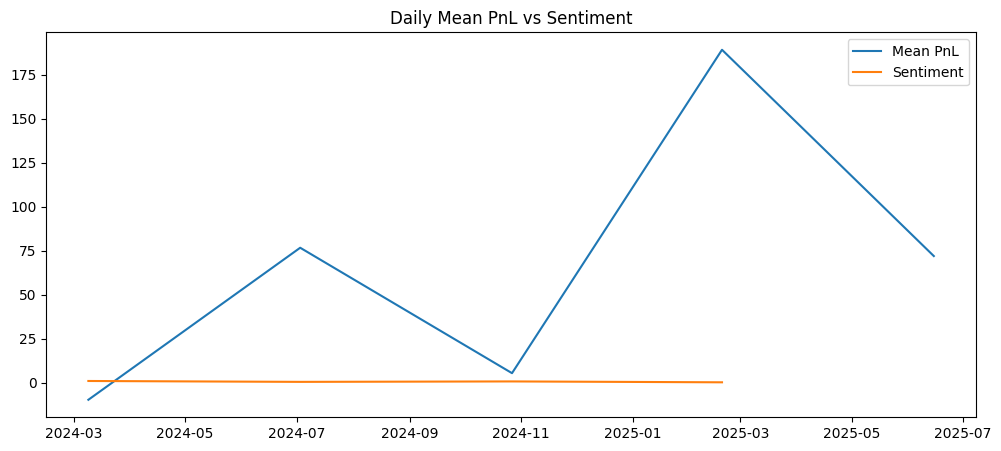

In [18]:
daily = merged.groupby('trade_date').agg(
mean_pnl=('closed_pnl','mean'),
win_rate=('profitable','mean'),
sentiment=('sentiment_score','mean')
).reset_index()


daily.to_csv("csv_files/daily_summary.csv", index=False)


plt.figure(figsize=(12,5))
plt.plot(daily['trade_date'], daily['mean_pnl'], label='Mean PnL')
plt.plot(daily['trade_date'], daily['sentiment'], label='Sentiment')
plt.legend()
plt.title("Daily Mean PnL vs Sentiment")
plt.savefig("outputs/daily_pnl_vs_sentiment.png", dpi=200)
plt.show()

Predictive Modeling (XGBoost) - Profitability Classification

Now we build a model to predict whether a trade will be profitable based on its features.

In [19]:
features = ['sentiment_score','size_usd','notional'] # Removed 'leverage' and changed 'size' to 'size_usd'
X = merged[features].fillna(0)
y = merged['profitable']


X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)


model = xgb.XGBClassifier(n_estimators=200,max_depth=4,use_label_encoder=False,eval_metric='auc')
model.fit(X_train,y_train)


y_proba = model.predict_proba(X_test)[:,1]
print("ROC AUC:", roc_auc_score(y_test,y_proba))
print(classification_report(y_test, model.predict(X_test)))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [08:45:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


ROC AUC: 0.6418332379550904
              precision    recall  f1-score   support

           0       0.66      0.88      0.76      3475
           1       0.57      0.25      0.35      2112

    accuracy                           0.65      5587
   macro avg       0.62      0.57      0.55      5587
weighted avg       0.63      0.65      0.60      5587



SHAP Feature Importance -

To interpret the model, we use **SHAP values** (SHapley Additive exPlanations).

- SHAP explains how each feature (sentiment, leverage, size, notional) influences predictions.
- This allows us to rank the drivers of profitability and check whether sentiment is a meaningful contributor.
- The summary plot highlights both the **magnitude and direction** of feature effects.


In [22]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, show=False)
plt.savefig("outputs/shap_summary.png", dpi=200)
plt.close()